In [1]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from slsim.Pipelines.skypy_pipeline import SkyPyPipeline
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
from slsim.selection import deflector_cut
import corner
from lenstronomy.Util import constants
from colossus.cosmology import cosmology
import numpy.random as random
from slsim.Util import param_util
import pandas as pd
import sys
from slsim.lens import Lens
from slsim.Deflectors.deflector import Deflector
import hmf
from hmf.halos import mass_definitions as md
# sys.path.append('../slsim')
# from lens_pop import LensPop
# from lensed_population_base import LensedPopulationBase
# sys.path.append('../slsim/Deflectors')  # 別ディレクトリのパスを追加
# from deflectors_base import DeflectorsBase
# from compound_lens_halos_galaxies import CompoundLensHalosGalaxies
# from lenstronomy.Util import constants
# from velocity_dispersion import vel_disp_composite_model
# sys.path.append('../slsim/Pipelines')  # 別ディレクトリのパスを追加
# from sl_hammocks_pipeline import SLHammocksPipeline

cosmo_col = cosmology.setCosmology('planck18')
cosmo = FlatLambdaCDM(H0=cosmo_col.H0, Om0=cosmo_col.Om0)


In [2]:
import numpy as np
from lenstronomy.Util import constants
from astropy.table import Table

import slsim.Deflectors.galaxy_population as galaxy_population
import slsim.Deflectors.halo_population as halo_population
from colossus.cosmology import cosmology
def csv_translator_for_slsim(table):
    """
        :param csv_table: original deflector population from csv file found in slhammocks_config which is generated by SL-Hammocks
        :type csv_table: astropy.table
    """
    # csv_table.rename_column("zl", "z")
    # csv_table.rename_column("con", "concentration")
    # csv_table.rename_column("m_g", "stellar_mass")
    # csv_table.rename_column("m_h", "halo_mass")
    # csv_table.rename_column("m_acc", "halo_mass_acc")
    if 'z' not in table.colnames:
        table.rename_column('zl', 'z')
    if 'concentration' not in table.colnames:
        table.rename_column('con', 'concentration')
    if 'stellar_mass' not in table.colnames:
        table.rename_column('m_g', 'stellar_mass')
    if 'halo_mass' not in table.colnames:
        table.rename_column('m_h', 'halo_mass')
    if 'halo_mass_acc' not in table.colnames:
        table.rename_column('m_acc', 'halo_mass_acc')
    return table

slhammocks_config='/Users/ktabe/Research/strong-lens-SNe/slsim_KTA/data/SL-Hammocks/pop_salp_a0001_zl001_to_5_wo_sub.csv'
table = Table.read(slhammocks_config, format="csv")
table = csv_translator_for_slsim(table)
table

col0,z,halo_mass,halo_mass_acc,e_h,p_h,concentration,stellar_mass,e_g,p_g,tb,vel_disp
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.022,110662400000.0,0.0,0.1507349,-9.519763,13.72977,1080892000.0,0.4210705,-27.15581,5.840332,54.11351611935491
1000,0.576,3548134000000.0,0.0,0.3829286,72.05911,6.484948,87221260000.0,0.4837437,46.38458,0.1061987,204.3720453546389
2000,0.765,516416400000.0,0.0,0.4977757,122.247,7.572108,17768070000.0,0.1646521,127.6121,0.04912861,127.851230286198
3000,0.911,148593600000.0,0.0,0.4534484,-46.85858,10.90592,548169400.0,0.4837566,-35.74009,0.1274478,52.00127681958947
4000,1.037,169824400000.0,0.0,0.184639,122.1807,6.316697,816558200.0,0.3848487,166.7035,0.1198332,42.53282987528342
5000,1.154,229086800000.0,0.0,0.202068,-29.99197,3.972965,1236293000.0,0.3704674,-16.34382,0.05697951,37.80321361734811
6000,1.264,144211500000.0,0.0,0.3566259,165.1809,7.026705,619452300.0,0.09381935,192.0172,0.1238609,46.56576945541271
7000,1.37,210862800000.0,0.0,0.1852096,-2.915689,5.302036,1323176000.0,0.3063853,5.763391,0.1009176,45.327222552049726
8000,1.473,164059000000.0,0.0,0.02291373,110.3108,5.623022,915614600.0,0.2372075,156.3429,0.1232049,46.50312215923301


# Galaxy-galaxy simulations

This notebook walks through the basics of simulating a galaxy-galaxy strong lensing population.
The underlying 

assumptions of the galaxy populations (for both lenses and sources) are drawn from a population pre-configured

 and rendered through [SkyPy](https://github.com/skypyproject/skypy). The specific settings are described in the [readme file](https://github.com/LSST-strong-lensing/slsim/tree/gg-lensing/data/SkyPy).

The notebook goes in three steps:

1. The populations of lenses and sources is produced.
2. Random draws of the population are generated and realized as images
3. The full population is generated in catalogue form
4. the full population is represented in a corner plot



## Generate population of galaxies and (potential) deflectors
The LensPop() class in the slsim package is used to produce a set of galaxies (as lenses and sources)

as seen on the sky within a certain sky area.
We use the default SkyPy configuration file. Alternative configuration

files can be used.

In [5]:
# define a cosmology

cosmo_col = cosmology.setCosmology('planck18')
cosmo = FlatLambdaCDM(H0=cosmo_col.H0, Om0=cosmo_col.Om0)

# define a sky area
sky_area = Quantity(value=0.01, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.0}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

skypy_config='/Users/ktabe/Research/strong-lens-SNe/slsim/data/SkyPy/lsst-like.yml'
# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop2 = LensPop(
    deflector_type="elliptical",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [35]:
z=1
cosmo_col = cosmology.setCosmology('myCosmo', params = cosmology.cosmologies['planck18'], Om0 = cosmo.Om0, H0 = cosmo.H0.value)
dis = cosmo_col.angularDiameterDistance(z) / (cosmo_col.H0 / 100.0)
drdz = (2997.92458 / ((1.0 + z) * cosmo_col.Ez(z))) / (cosmo_col.H0 / 100.0)
dis

1697.7700262438145

In [3]:
# sys.path.append('../slsim/Pipelines')
# import galaxy_population
# import halo_population
# import global_value as g

# define a cosmology

cosmo_col = cosmology.setCosmology('planck18')
cosmo = FlatLambdaCDM(H0=cosmo_col.H0, Om0=cosmo_col.Om0)

# define a sky area
sky_area = Quantity(value=0.01, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut ={"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.0}
# {
#     'sig_c': 0.33,
#     'sig_c_sh': 0.33,
#     'sig_mcen': 0.2,
#     'sig_msat': 0.2,
#     'sig_tb': 0.46,
#     'TYPE_GAL_SIZE': 'vdW23',
#     'frac_SM_IMF': 1.715,
#     'TYPE_SMHM': 'true',
#     'area': sky_area.value,
#     'zmin': 0.01,
#     'zmax': 5.0,
#     'Mhmin': 1e11,
#     'Mhmax': 1e16,
#     'switch_sub': False,
#     'halo_gal_pop_array': np.empty((0, 10), float),
#     'dz': 0.001,
#     'zz_ar': np.arange(0.01, 5.001, 0.001),
#     'dlogMh': 0.001,
#     'dlnMh': np.log(10**0.001),
#     'MMh': 10**np.arange(np.log10(1e11), np.log10(1e16), 0.001),
#     'min_Msh': 1e11 / 10
# }
#
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

skypy_config='/Users/ktabe/Research/strong-lens-SNe/slsim_KTA/data/SkyPy/lsst-like.yml'
slhammocks_config='/Users/ktabe/Research/strong-lens-SNe/slsim_KTA/data/SL-Hammocks/pop_salp_a0001_zl001_to_5_wo_sub.csv'
# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="halo-models",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    slhammocks_config=slhammocks_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

Now sky_area should be lower than 0.001 . Now we set sky_area_for_lens= 0.001
Please check https://github.com/LSST-strong-lensing/data_public for the full data file


In [2]:
# sys.path.append('../slsim/Pipelines')
# import lens_gals
# import lens_halo
# import global_value as g

# define a cosmology

cosmo_col = cosmology.setCosmology('planck18')
cosmo = FlatLambdaCDM(H0=cosmo_col.H0, Om0=cosmo_col.Om0)

# define a sky area
sky_area = Quantity(value=0.01, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.0}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

skypy_config='/Users/ktabe/Research/strong-lens-SNe/slsim_KTA/data/SkyPy/lsst-like.yml'
slhammocks_config=None#'/Users/ktabe/Research/strong-lens-SNe/slsim_KTA/data/SL-Hammocks/gal_pop_Salpeter_10deg2_zl2.csv'
# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop3 = LensPop(
    deflector_type="halo-models",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    slhammocks_config=slhammocks_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

(array([104., 210., 291., 309., 268., 198., 113.,  62.,  25.,   8.]),
 array([0.00220147, 0.0981394 , 0.19407734, 0.29001528, 0.38595321,
        0.48189115, 0.57782908, 0.67376702, 0.76970495, 0.86564289,
        0.96158083]),
 <BarContainer object of 10 artists>)

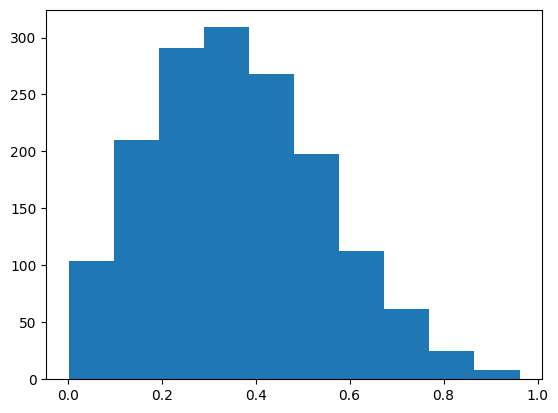

In [4]:

plt.hist(gg_lens_pop3._lens_galaxies._galaxy_select['e_g'])


In [3]:
# print(gg_lens_pop._lens_galaxies._num_select)
print(gg_lens_pop3._lens_galaxies._num_select)

1612


(array([665., 400., 240., 133.,  77.,  40.,  20.,  11.,   9.,   4.]),
 array([11.    , 11.2356, 11.4712, 11.7068, 11.9424, 12.178 , 12.4136,
        12.6492, 12.8848, 13.1204, 13.356 ]),
 <BarContainer object of 10 artists>)

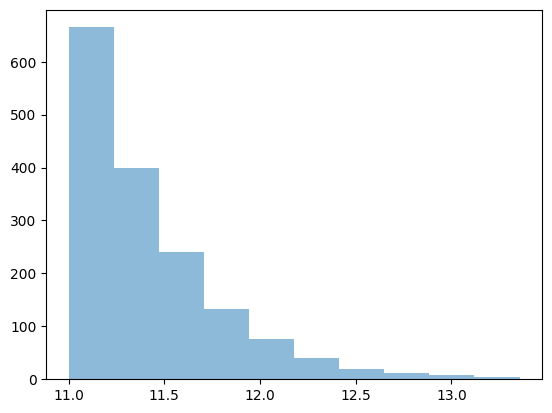

In [3]:
# plt.hist(np.log10(gg_lens_pop._lens_galaxies._galaxy_select['halo_mass']))
plt.hist(np.log10(gg_lens_pop3._lens_galaxies._galaxy_select['halo_mass']),alpha=0.5)

In [5]:
gg_lens_pop3._lens_galaxies.draw_deflector()

z,halo_mass,halo_mass_acc,e_h,p_h,concentration,stellar_mass,e_g,p_g,tb,angular_size,vel_disp,mag_g,mag_r,mag_i,mag_z,mag_Y,e1_light,e2_light,e1_mass,e2_mass
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.9569999999999992,407380277803.7956,0.0,0.13290431203118563,119.06220294334727,3.9777239731416962,8314765773.82698,0.31251481791987373,68.16867977803352,0.0781046411182528,6.872268343426382e-07,70.94345480569933,-1.0,-1.0,-1.0,-1.0,-1.0,0.15478894426172457,0.04155996172501363,0.11238010966804383,0.029974762119019865


In [3]:
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.0}

# skypy_config='/Users/ktabe/Research/strong-lens-SNe/slsim_KTA/data/SL-Hammocks/gal_pop_Salpeter_10deg2_zl2.csv'
# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop3 = LensPop(
    deflector_type="halo-models",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    slhammocks_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [14]:
np.log10(min(gg_lens_pop3._lens_galaxies._galaxy_select['halo_mass'])), max(gg_lens_pop._lens_galaxies._galaxy_select['z'])

(11.0, 2.0)

In [16]:
gg_lens_pop2._lens_galaxies._galaxy_select

z,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_Y,vel_disp,e1_light,e2_light,e1_mass,e2_mass,n_sersic
,,,,kpc,,rad,,,,,,,,,,,
float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.998556467041887,-23.221930182705094,0.014580211315256678 .. 0.00027922589969713783,0.11027584342567216,8.674276868506373,1362166402924.5896,4.901372096006925e-06,26.155793174487254,25.825736045025362,25.34115550905506,24.253622952898798,23.37038440056583,320.89979378771886,-1.0,-1.0,-1.0,-1.0,-1.0
1.245565498299808,-22.974996971944865,0.18508847359910938 .. 0.0003963184870359315,0.1331387541393436,7.395465680627259,909925740694.5557,4.18853018660978e-06,24.426704629734026,23.58312550138792,22.477269702980564,21.670283208389918,20.95890992982782,316.1204312000873,-1.0,-1.0,-1.0,-1.0,-1.0
1.8189013263925555,-22.76695794207456,0.10993758466828976 .. 0.00037168068272003696,0.05188227237178492,6.204887165889491,852246371379.467,3.4766009841457494e-06,24.137088281386987,24.04613536114573,23.980219166406442,23.484021379795998,23.096387678296622,313.4358968727419,-1.0,-1.0,-1.0,-1.0,-1.0
1.836493080508662,-22.429516444446627,0.1476462310850743 .. 0.0008995252026049224,0.11438565841533611,6.6033230962994365,634447688365.5225,3.7022935720263365e-06,25.35211638036161,25.165927985804647,24.93085473946662,24.130543677844404,23.632483985394362,301.5380235349734,-1.0,-1.0,-1.0,-1.0,-1.0
1.8084675767918517,-22.502018226829676,0.07893805601131923 .. 0.00044702816493207204,0.14277636980440256,8.418839480053837,631142261446.193,4.715317659086048e-06,25.149616497789168,24.963278736518916,24.71061676798187,23.935239971518705,23.465706432217004,301.03909335635694,-1.0,-1.0,-1.0,-1.0,-1.0
1.7074185438324543,-22.4546339772828,0.07335159633362477 .. 0.0020494318993501868,0.06903031968349306,5.726683981683717,626685468564.9553,3.198398953780591e-06,25.428622704802642,25.171564296155047,24.55589050900943,23.72639275098895,23.287359440851468,300.31972715629803,-1.0,-1.0,-1.0,-1.0,-1.0
1.108378917115437,-22.42219937825867,0.04710549480099161 .. 0.00040796903920647167,0.13216772950084588,4.52362440184417,617468632463.3743,2.6080785863222885e-06,24.509668088427627,23.445614966813718,22.46876164862169,21.575547962590502,20.948859966120448,298.27174944403095,-1.0,-1.0,-1.0,-1.0,-1.0
1.836631778276361,-22.29888727837126,0.044762121879074177 .. 0.0004089690055280359,0.5785462808439199,4.466526692665602,565780104760.9315,2.504266664429605e-06,26.827457172900324,26.392092162635564,25.74302871998055,24.46617316123782,23.852403470080937,297.7316406544439,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
import numpy as np
from astropy.table import Table

# 2x2のNumPy配列を作成する
np_array = np.array([[1, 2], [3, 4]])

# Astropyテーブルを作成し、NumPy配列を列として追加する
table = Table(np_array, names=['column_name1', 'column_name2'])

# 変換後のAstropyテーブルを表示する
print(table)


column_name1 column_name2
------------ ------------
           1            2
           3            4


In [3]:
kwargs_deflector_base = {
    'sig_c': 0.33,
    'sig_c_sh': 0.33,
    'sig_mcen': 0.2,
    'sig_msat': 0.2,
    'sig_tb': 0.46,
    'TYPE_GAL_SIZE': 'vdW23',
    'frac_SM_IMF': 1.715,
    'TYPE_SMHM': 'true',
    'zmin': 0.01,
    'zmax': 5.0,
    'Mhmin': 1e11,
    'Mhmax': 1e16,
    'switch_sub': False,
    'halo_gal_pop_array': np.empty((0, 10), float),
    'dz': 0.001,
    'zz_ar': np.arange(0.01, 5.001, 0.001),
    'dlogMh': 0.001,
    'dlnMh': np.log(10**0.001),
    'MMh': 10**np.arange(np.log10(1e11), np.log10(1e16), 0.001),
    'min_Msh': 1e11 / 10
}

kwargs_deflector_cut = {
    'sig_c': 0.10,
    'TYPE_GAL_SIZE': 'OT20',
    'frac_SM_IMF': 1.715,
    'TYPE_SMHM': 'true',
    'zmin': 0.01,
    'zmax': 3.0,
}

def update_dictionary(original_dict, **kwargs):
    for key, value in kwargs.items():
        if key in original_dict:
            original_dict[key] = value
        else:
            print(f"Key '{key}' not found in the dictionary")
    return original_dict

udict = update_dictionary(kwargs_deflector_base, **kwargs_deflector_cut)
udict

{'sig_c': 0.1,
 'sig_c_sh': 0.33,
 'sig_mcen': 0.2,
 'sig_msat': 0.2,
 'sig_tb': 0.46,
 'TYPE_GAL_SIZE': 'OT20',
 'frac_SM_IMF': 1.715,
 'TYPE_SMHM': 'true',
 'zmin': 0.01,
 'zmax': 3.0,
 'Mhmin': 100000000000.0,
 'Mhmax': 1e+16,
 'switch_sub': False,
 'halo_gal_pop_array': array([], shape=(0, 10), dtype=float64),
 'dz': 0.001,
 'zz_ar': array([0.01 , 0.011, 0.012, ..., 4.998, 4.999, 5.   ]),
 'dlogMh': 0.001,
 'dlnMh': 0.0023025850929939925,
 'MMh': array([1.00000000e+11, 1.00230524e+11, 1.00461579e+11, ...,
        9.93116048e+15, 9.95405417e+15, 9.97700064e+15]),
 'min_Msh': 10000000000.0}

In [55]:
deflector_dict = np.argmax(gg_lens_pop._lens_galaxies._galaxy_select['halo_mass'])
deflector_dict

48

In [7]:
from slsim.Deflectors.DeflectorTypes.nfw_hernquist import NFWHernquist
source_dict = gg_lens_pop._sources.draw_source()
deflector_dict = gg_lens_pop3._lens_galaxies.draw_deflector()
# deflector_dict2 = gg_lens_pop2._lens_galaxies.draw_deflector()
a = gg_lens_pop._lens_galaxies._galaxy_select['halo_mass']
# source_dict['z'], deflector_dict, deflector_dict2['vel_disp']

In [10]:
scatter = True
if scatter:
    print("yes")

yes


In [8]:
deflector = NFWHernquist(deflector_dict=deflector_dict)
deflector.stellar_mass, deflector.halo_properties

(838712731.7087927, (175090269611.83795, 5.5553119079142945))

In [20]:
source_dict['z'],deflector_dict['z']

(0.16973150227387734, 0.7839999999999994)

In [ ]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lens_cosmo = LensCosmo(
            z_lens=float(deflector_dict.redshift),
            z_source=float(source_dict.redshift),
            cosmo=cosmo,
        )

In [58]:
gg_lens = Lens(
        source_dict,
        deflector_dict,
        cosmo,
        deflector_type="NFW_HERNQUIST",
        source_type="extended",
        lens_equation_solver="lenstronomy_analytical",
        variability_model=None,
        kwargs_variability=None,
        sn_type=None,
        sn_absolute_mag_band=None,
        sn_absolute_zpsys=None,
        test_area=4 * np.pi,
        mixgauss_means=None,
        mixgauss_stds=None,
        mixgauss_weights=None,
        magnification_limit=0.01,
        light_profile="single_sersic",
        lightcurve_time=None,
    )

gg_lens2 = Lens(
        source_dict,
        deflector_dict2,
        cosmo,
        deflector_type="EPL",
        source_type="extended",
        lens_equation_solver="lenstronomy_analytical",
        variability_model=None,
        kwargs_variability=None,
        sn_type=None,
        sn_absolute_mag_band=None,
        sn_absolute_zpsys=None,
        test_area=4 * np.pi,
        mixgauss_means=None,
        mixgauss_stds=None,
        mixgauss_weights=None,
        magnification_limit=0.01,
        light_profile="single_sersic",
        lightcurve_time=None,
    )

In [59]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
lens_model_list, kwargs_lens = gg_lens2.deflector_mass_model_lenstronomy()
lens_model = LensModel(lens_model_list=lens_model_list, z_source_convention=1000)
lens_analysis = LensProfileAnalysis(lens_model=lens_model)
theta_E = lens_analysis.effective_einstein_radius(
    kwargs_lens, r_min=1e-6, r_max=100.0, num_points=50)


# lens_model_list2, kwargs_lens2 = gg_lens2.deflector_mass_model_lenstronomy()
# lens_model2 = LensModel(lens_model_list=lens_model_list2)
# lens_analysis2 = LensProfileAnalysis(lens_model=lens_model2)
# theta_E2 = lens_analysis2.effective_einstein_radius(
#     kwargs_lens2, r_min=1e-6, r_max=100.0, num_points=50)

print(kwargs_lens,lens_model_list, theta_E)
# print(kwargs_lens2,lens_model_list2,theta_E2)

[{'theta_E': 1.0813749614233952, 'gamma': 2, 'e1': -0.16373720740359413, 'e2': 0.15818465644884203, 'center_x': 0.0988554002749264, 'center_y': -0.10115871210005899}, {'gamma1': 0.028372267477532402, 'gamma2': -0.005941815130409935, 'ra_0': 0, 'dec_0': 0}, {'kappa': 0.017074293504680784, 'ra_0': 0, 'dec_0': 0}] ['EPL', 'SHEAR', 'CONVERGENCE'] 1.0710594886431368


In [25]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
lens_model_list, kwargs_lens = gg_lens2.deflector_mass_model_lenstronomy()
lens_model = LensModel(lens_model_list=lens_model_list, z_source_convention=1000)
lens_analysis = LensProfileAnalysis(lens_model=lens_model)
theta_E = lens_analysis.effective_einstein_radius(
    kwargs_lens, r_min=1e-6, r_max=10.0, num_points=50)


# lens_model_list2, kwargs_lens2 = gg_lens2.deflector_mass_model_lenstronomy()
# lens_model2 = LensModel(lens_model_list=lens_model_list2)
# lens_analysis2 = LensProfileAnalysis(lens_model=lens_model2)
# theta_E2 = lens_analysis2.effective_einstein_radius(
#     kwargs_lens2, r_min=1e-6, r_max=100.0, num_points=50)

print(kwargs_lens,lens_model_list, theta_E)
# print(kwargs_lens2,lens_model_list2,theta_E2)

[{'theta_E': 0.5641739349956584, 'gamma': 2, 'e1': -0.000759747226126268, 'e2': 0.10921183628686036, 'center_x': -0.01753885744033882, 'center_y': -0.14393943642585913}, {'gamma1': -0.0020684156945948895, 'gamma2': 0.0037826334857735287, 'ra_0': 0, 'dec_0': 0}, {'kappa': 0.08710126725122858, 'ra_0': 0, 'dec_0': 0}] ['EPL', 'SHEAR', 'CONVERGENCE'] 0.61441583271697


In [17]:
gg_lens.deflector_velocity_dispersion(),gg_lens2.deflector_velocity_dispersion()

(57.318277870321324, 33.22739046275703)

In [18]:
# lens_analysis.effective_einstein_radius_grid(kwargs_lens,center_x=0,center_y=0,)

nan

In [25]:
from lenstronomy.Util import util
from lenstronomy.Util import mask_util as mask_util
import lenstronomy.Util.multi_gauss_expansion as mge
from lenstronomy.Util import analysis_util
import scipy
r_min=1e-6
r_max=10.0
num_points=100
r_array = np.logspace(np.log10(r_min), np.log10(r_max), num_points)
center_x, center_y = analysis_util.profile_center(
    kwargs_lens, center_x=0, center_y=0
)
kappa_list = []
for r in r_array:
    x, y = util.points_on_circle(r, num_points=20)
    f_r = lens_model.kappa(
        x + center_x, y + center_y, kwargs=kwargs_lens, k=None
    )
    kappa_list.append(np.average(f_r))

kappa_r = kappa_list
# here we make a finer grid interpolation in log-log space
k_interp = scipy.interpolate.interp1d(np.log10(r_array), np.log10(kappa_r))
r_array = np.logspace(np.log10(r_min), np.log10(r_max), num_points * 10)
kappa_r = 10 ** k_interp(np.log10(r_array))

# we perform the integral in logarithmic steps of the convergence
kappa_r = np.array(kappa_r)
kappa_r_ = (kappa_r[1:] + kappa_r[:-1]) / 2
r_array_ = (r_array[1:] + r_array[:-1]) / 2
dlog_r = (np.log10(r_array[2]) - np.log10(r_array[1])) * np.log(10)
# add the mass within the innermost bin and assume it's constant
kappa_innermost = kappa_r[0] * np.pi * r_array[0] ** 2

# the first part is the logarithmic integrand, the second part the circle integrand
kappa_slice = kappa_r_ * dlog_r * r_array_ * (2 * np.pi * r_array_)
kappa_slice = np.append(kappa_innermost, kappa_slice)

kappa_cdf = np.cumsum(kappa_slice)
# calculate average convergence at radius
kappa_average = kappa_cdf / (np.pi * r_array**2)

# we interpolate as the inverse function and evaluate this function for average kappa = 1
# (assumes monotonic decline in average convergence)
# inv_interp = scipy.interpolate.interp1d(
#     np.log10(kappa_average), np.log10(r_array)
# )
# np.log10(kappa_average),inv_interp(max(np.log10(kappa_average)))
kappa_list
# try:
#     theta_e = 10 ** inv_interp(0)
# except:
#     theta_e = np.nan
# theta_e


[0.3471820793592025,
 0.3471820677601571,
 0.34718205411081476,
 0.347182038048871,
 0.3471820191480437,
 0.34718199690679236,
 0.34718197073505525,
 0.3471819399386578,
 0.3471819037009888,
 0.3471818610614671,
 0.34718181089024724,
 0.3471817518585136,
 0.34718168240360775,
 0.3471816006881091,
 0.34718150455184393,
 0.347181391455637,
 0.34718125841543135,
 0.34718110192519736,
 0.3471809178668138,
 0.34718070140485074,
 0.3471804468639076,
 0.3471801475858657,
 0.347179795764123,
 0.34717938225159506,
 0.3471788963390273,
 0.3471783255000095,
 0.3471776550990754,
 0.34717686805950554,
 0.34717594448806344,
 0.34717486125508035,
 0.34717359153035354,
 0.3471721042786081,
 0.34717036372340565,
 0.3471683287961126,
 0.3471659525980358,
 0.3471631819206368,
 0.3471599568930935,
 0.34715621086144954,
 0.34715187065353414,
 0.347146857454758,
 0.347141088620238,
 0.34713448089020643,
 0.34712695567472807,
 0.3471184473532595,
 0.3471089159265189,
 0.34709836590726995,
 0.3470868741057712

## Test halo mass conversion

In [8]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

cosmology.setCosmology('WMAP9')
mfunc_so = mass_function.massFunction(1E12, 0.0, mdef = 'fof', model = 'sheth99')

In [48]:
from colossus.halo import mass_defs

Mvirs = table['halo_mass']
cvirs = table['concentration']
z_s = table['z']
M200_array = []
c200_array = []
for i in range(len(z_s)):
    M200, r200, c200 = mass_defs.changeMassDefinition(Mvirs[i], cvirs[i], z_s[i], 'vir', '200c')
    M200_array.append(M200)
    c200_array.append(c200)
M200_array = np.array(M200_array)
c200_array = np.array(c200_array)
M200_array,c200_array

hubble = cosmo.H0.value / 100.0
table['halo_mass'] = (
    M200_array / hubble
)  # convert to Mvir [Msun/h] to physical M200c [Msun]
table['halo_mass_acc'] = (
    table['halo_mass_acc'] / hubble
)  # convert to Mvir [Msun/h] to physical M200c[Msun] Currently not supported
table['concentration'] = (
    c200_array
)
table['stellar_mass'] = (
    table['stellar_mass'] / hubble
)  # convert to stellar mass [Msun/h] to physical stellar mass [Msun]
table
# # M200_array, r200_array, c200_array = zip(*[mass_defs.changeMassDefinition(Mvir, cvir, z, 'vir', '200c') for Mvir, cvir, z in zip(table['halo_mass'], table['concentration'], table['z'])])
# M200_array, r200_array, c200_array = zip(*[mass_defs.changeMassDefinition(Mvir, cvir, z, 'vir', '200c') for Mvir, cvir, z in zip(table['halo_mass'], table['concentration'], table['z'])])

# M200_array = np.array(M200_array)
# c200_array = np.array(c200_array)

# M200_array, c200_array

col0,z,halo_mass,halo_mass_acc,e_h,p_h,concentration,stellar_mass,e_g,p_g,tb,vel_disp
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.022,142832261031.83215,0.0,0.1507349,-9.519763,10.572378475255391,1597534732.4859593,0.4210705,-27.15581,5.840332,54.11351611935491
1000,0.576,4757972519878.891,0.0,0.3829286,72.05911,5.612749728009598,128911114395.50696,0.4837437,46.38458,0.1061987,204.3720453546389
2000,0.765,708033538279.459,0.0,0.4977757,122.247,6.722593718892994,26260818799.881763,0.1646521,127.6121,0.04912861,127.851230286198
3000,0.911,207642584601.56036,0.0,0.4534484,-46.85858,9.844931854543955,810182382.500739,0.4837566,-35.74009,0.1274478,52.00127681958947
4000,1.037,234807623222.22086,0.0,0.184639,122.1807,5.722013889417409,1206855158.1436596,0.3848487,166.7035,0.1198332,42.53282987528342
5000,1.154,312891289508.3945,0.0,0.202068,-29.99197,3.603289890853103,1827214011.2326338,0.3704674,-16.34382,0.05697951,37.80321361734811
6000,1.264,201678735944.95407,0.0,0.3566259,165.1809,6.449867631847342,915536949.4531481,0.09381935,192.0172,0.1238609,46.56576945541271
7000,1.37,293351313089.63513,0.0,0.1852096,-2.915689,4.874588504500382,1955625184.7472658,0.3063853,5.763391,0.1009176,45.327222552049726
8000,1.473,229244376446.62952,0.0,0.02291373,110.3108,5.191626304115181,1353258350.5764115,0.2372075,156.3429,0.1232049,46.50312215923301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


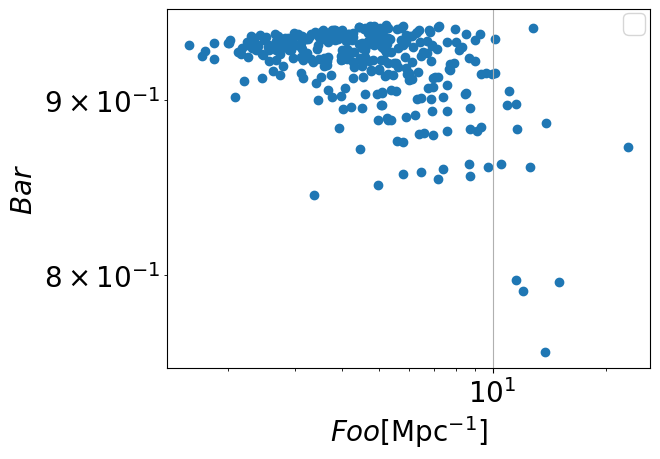

In [43]:
fig = plt.figure(figsize=(7, 5.))

ax = fig.add_subplot(111)
ax.grid()
plt.rcParams["font.size"] = 20
plt.tick_params(labelsize=20)
#ax.set_xlim(1e-4,4e-1)
#ax.set_ylim(1e-4,1.)
plt.xscale("log")
plt.yscale("log")
# plt.scatter(Mvirs, M200_array/Mvirs)
plt.scatter(cvirs, c200_array/cvirs)

plt.xlabel(r"$Foo[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$Bar$")
plt.legend(loc='upper right', 
           bbox_to_anchor=(0.99, 0.99), 
           borderaxespad=0.,
           ncol=2,
          fontsize=20.)
plt.tight_layout()
# plt.savefig("tmp_plots/test_plot.pdf")
plt.show()


In [3]:
mdef_1 = md.SOMean(overdensity=200)
mdef_2 = md.SOVirial()
mdef_3 = md.FOF()

In [6]:
mnew, rnew, cnew = mdef_2.change_definition(m=1e12, mdef=mdef_1)
mnew3, rnew3, cnew3 = mdef_3.change_definition(m=1e12, mdef=mdef_1)
mnew3, rnew3, cnew3 = mdef_3.change_definition(m=1e12, mdef=mdef_2)
mnew, rnew, cnew, mnew3, rnew3, cnew3

(1137000786564.2122,
 0.2514735105816359,
 8.834441694015762,
 838836244557.61,
 0.19186177057393847,
 5.485045834545732)

# Test generate dataframe

In [82]:
g.sig_c

0.33

In [92]:

# Scatter of concentration params for halos & gals in log-normal distribution
sig_c = 0.33  # Intrinsic scatter (https://arxiv.org/abs/astro-ph/0608157)
sig_c_sh = 0.33  # Intrinsic scatter (https://arxiv.org/abs/astro-ph/0608157)
sig_mcen = 0.2  # Intrinsic scatter (https://iopscience.iop.org/article/10.3847/1538-4357/ac4cb4/pdf)
sig_msat = 0.2
sig_tb = 0.46

# method to calculate galaxy half-light effective size (or rb in Hernquist profile)
# options: 'vdW23'(JWST-base), 'oguri20'(simple), 'karmakar23'(IllustrisTNG-base), (default 'vdW23')
TYPE_GAL_SIZE = 'vdW23'

# fraction of Stellar mass-to-light ratio in respect to Chabrier IMF
# Chabrier: frac_SM_IMF=1.0, Salpeter: =1.715 (default 1.715)
frac_SM_IMF = 1.715

# type of fitting formula of the stellar-mass-halo-mass relation
# options: 'true','true_all','obs', see Berhoozi et al. 2019 Table J1
# default 'true'
TYPE_SMHM = 'true'
paramc, params = lens_gals.gals_init(TYPE_SMHM)

# cosmological parameters
area = sky_area.value
zmin=0.01
zmax=5.0
Mhmin=1e11
Mhmax=1e16
switch_sub=False
halo_gal_pop_array = np.array([])
halo_gal_pop_array = np.empty((0,10), float)
dz = 0.001
zz_ar = np.arange(zmin, zmax + dz, dz)
dlogMh = 0.001
dlnMh = np.log(10**dlogMh)
MMh = 10**np.arange(np.log10(Mhmin),
                    np.log10(Mhmax), dlogMh)
min_Msh =Mhmin/10.

frac_SM_IMF = 1.715
#     if switch_sub:
#         n_bins = 100
#         output_length = n_bins-1
#         interp_dnsh, interp_msh_acc_Mh = lens_subhalo.create_interp_dndmsh(0, zmax+0.1, Mhmin/2., Mhmax*2., min_Msh, cosmo, n_bins=n_bins)

# Start for loop-1 of redshift
for zz in zz_ar:
    zz2 = np.full(len(MMh), zz)
    NNh = area * \
        lens_halo.dNhalodzdlnM_lens(MMh, zz2, cosmo_col) * dlnMh * dz
    Nh = np.random.poisson(NNh)
    indices = np.nonzero(Nh)[0]
    if len(indices) == 0:
        continue

    zl_tab = np.repeat(zz2[indices], Nh[indices])
    Mhosthl_tab  = np.repeat(MMh[indices], Nh[indices])
    conhl_tab = lens_halo.concent_m_w_scatter(Mhosthl_tab, zz, g.sig_c)
    # in physical [Mpc/h]
    eliphl_tab, polarhl_tab = solve_lenseq.gene_e_ang_halo(Mhosthl_tab)

    mshsat_tot = 0
    Mhosthl_tab_re = Mhosthl_tab

#         if switch_sub == True:
#             Mhl_zl_tab_vec = np.vstack((np.log10(Mhosthl_tab),  zl_tab)).T
#             dnshp = interp_dnsh(Mhl_zl_tab_vec).reshape(
#                 len(Mhosthl_tab), output_length)
#             msh_acc_Mh = interp_msh_acc_Mh(Mhl_zl_tab_vec).reshape(
#                 len(Mhosthl_tab), output_length)
#             dnsh = np.where((msh_acc_Mh > 0.5) | (dnshp < 1.0e-4), 0., dnshp)
#             mmsh_acc = msh_acc_Mh*Mhosthl_tab.reshape(len(Mhosthl_tab), -1)
#             mmsh = np.logspace(np.log10(min_Msh), np.log10(
#                 Mhosthl_tab/2.), n_bins).T[:, 1:]  # in [Modot/h]
#             NNsh = np.random.poisson(dnsh)

#             # Start: for-loop-2 of host halos
#             for j, (mh, zl) in enumerate(zip(Mhosthl_tab, zl_tab)):
#                 indices_sh = np.nonzero(NNsh[j])[0]
#                 cut_Nsh = NNsh[j][indices_sh]
#                 cut_msh = mmsh[j][indices_sh]
#                 cut_msh_acc = mmsh_acc[j][indices_sh]
#                 # Subhalo mass
#                 msh_tab = np.repeat(cut_msh, cut_Nsh)
#                 msh_acc_tab = np.repeat(cut_msh_acc, cut_Nsh)
#                 zsub_tab = np.full(len(msh_tab), zz)
#                 mshsat_tot = 0
#                 # Start: If at least one subhalo exists in loop-2 of host halos
#                 if len(msh_tab) != 0:
#                     # Satellite gals
#                     msat_ave = lens_gals.stellarmass_halomass(
#                         msh_acc_tab/(cosmo.H0/100.), zl, g.params, g.frac_SM_IMF)*(cosmo.H0/100.)  # KA
#                     msat_scat = np.random.lognormal(0.0, g.sig_msat, len(msh_acc_tab))
#                     msat_tab = msat_ave*msat_scat

#                     mshsat_tot = sum(msh_tab)+sum(msat_tab)
#                     elipsh_tab, polarsh_tab = solve_lenseq.gene_e_ang_halo(msh_acc_tab)
#                     con_sh_ave = np.where(lens_subhalo.concent_m_sub_ando(msh_tab, zl, cosmo) > lens_halo.concent_m(msh_tab, zl),
#                                       lens_subhalo.concent_m_sub_ando(msh_tab, zl, cosmo), lens_halo.concent_m(msh_tab, zl))
#                     cor_con_sh = mass_so.M_to_R(
#                         msh_acc_tab, zl, 'vir') / mass_so.M_to_R(msh_tab, zl, 'vir')
#                     con_sh_tab = con_sh_ave * \
#                         cor_con_sh * np.random.lognormal(0.0, g.sig_c_sh, len(msh_tab))
#                     elipsat_tab, polarsat_tab = lens_gals.set_gals_param(polarsh_tab)
#                     tb_sat_tab = lens_gals.galaxy_size(
#                          msh_acc_tab, msat_tab/g.frac_SM_IMF, zz, cosmo, model=g.TYPE_GAL_SIZE, scatter=True, sig_tb=g.sig_tb)
#                     halogal_par_mat = np.hstack((zsub_tab.reshape(-1, 1), msh_tab.reshape(-1, 1),  msh_acc_tab.reshape(-1, 1), elipsh_tab.reshape(-1, 1), polarsh_tab.reshape(-1, 1), con_sh_tab.reshape(-1, 1), msat_tab.reshape(-1, 1), elipsat_tab.reshape(-1, 1), polarsat_tab.reshape(-1, 1), tb_sat_tab.reshape(-1, 1)))

#                     result_halogal_par.append(halogal_par_mat)
#                 # End: If at least one subhalo exists in loop-2 of host halos

#                 Mhosthl_tab_re[j] = mh-mshsat_tot

    Mcenl_ave = lens_gals.stellarmass_halomass(Mhosthl_tab_re / (cosmo_col.H0 / 100.), zl_tab, g.paramc, g.frac_SM_IMF) * (cosmo_col.H0 / 100.)
    Mcenl_scat = np.random.lognormal(0.0, g.sig_mcen, size=Mhosthl_tab_re.shape)
    Mcenl_tab = Mcenl_ave * Mcenl_scat

    elipcenl, polarcenl = lens_gals.set_gals_param(polarhl_tab)
    tb_cen = lens_gals.galaxy_size(Mhosthl_tab_re, Mcenl_tab/g.frac_SM_IMF, zl_tab, cosmo_col, model=g.TYPE_GAL_SIZE, scatter=True, sig_tb=g.sig_tb)
    halogal_par_mat = np.hstack((zl_tab.reshape(-1, 1), Mhosthl_tab_re.reshape(-1, 1), np.zeros_like(Mhosthl_tab).reshape(-1, 1), eliphl_tab.reshape(-1, 1), polarhl_tab.reshape(-1, 1), conhl_tab.reshape(-1, 1),
                                    Mcenl_tab.reshape(-1, 1), elipcenl.reshape(-1, 1), polarcenl.reshape(-1, 1), tb_cen.reshape(-1, 1)))

    halo_gal_pop_array = np.append(halo_gal_pop_array, halogal_par_mat, axis=0)
# data_frame_pop = pd.DataFrame(halo_gal_pop_list)

# data_frame_pop

In [99]:
columns_pop = ["z", "halo_mass", "halo_mass_acc", "e_h" , "p_h", "concentration", "stellar_mass", "e_g", "p_g", "tb"]
data_frame_pop = pd.DataFrame(halo_gal_pop_array)
data_frame_pop.columns =columns_pop
data_frame_pop

,z,halo_mass,halo_mass_acc,e_h,p_h,concentration,stellar_mass,e_g,p_g,tb
0,0.075,2.600160e+11,0.0,0.145123,115.552317,9.760382,5.865524e+09,0.373607,140.399393,0.365735
1,0.091,2.182730e+11,0.0,0.182705,-25.663141,13.494212,3.716412e+09,0.232750,-90.596291,0.397336
2,0.105,1.462177e+11,0.0,0.510557,-59.927349,9.158950,1.803778e+09,0.266069,-69.402165,0.689494
3,0.107,2.857591e+11,0.0,0.082263,-39.738060,13.614227,5.151813e+09,0.599937,33.779926,0.203443
4,0.113,1.606941e+11,0.0,0.294678,-26.069737,10.675590,2.071995e+09,0.169438,-8.782146,0.776613
...,...,...,...,...,...,...,...,...,...,...
32324,4.997,1.023293e+11,0.0,0.099154,111.671446,2.448956,6.121657e+08,0.297413,97.413709,0.184843
32325,4.997,1.037528e+11,0.0,0.096262,-45.937216,4.559088,3.953498e+08,0.468007,0.791494,0.041592
32326,4.998,1.078947e+11,0.0,0.125211,40.247689,4.835674,3.391498e+08,0.277973,-39.793874,0.045571
32327,4.998,1.227439e+11,0.0,0.542791,-155.775944,4.452229,5.875778e+08,0.386369,-165.288244,0.099346


In [ ]:
def halo_galaxy_population(sky_area,cosmo,cosmo_col,z_min,z_max,log10host_halo_mass_min,log10host_halo_mass_max,
                           log10subhalo_mass_min, sigma_host_halo_concentration, sigma_subhalo_concentration,
                           sigma_central_galaxy_mass, sigma_satellite_galaxy_mass, sig_tb,
                           TYPE_GAL_SIZE,frac_SM_IMF, TYPE_SMHM, switch_sub,**kwargs):
    dz = 0.001
    dlogMh = 0.001
    dlnMh = np.log(10**dlogMh)
    # cosmological parameters
    area = sky_area.value
    halo_gal_pop_array = np.array([])
    halo_gal_pop_array = np.empty((0,10), float)
    zz = np.arange(z_min, z_max + dz,dz)
    Mh_min = 10**log10host_halo_mass_min
    Mh_max = 10**log10host_halo_mass_max
    MMh = 10**np.arange(np.log10(Mh_min),
                        np.log10(Mh_max), dlogMh)
    min_Msh =10**log10subhalo_mass_min
    paramc, params = lens_gals.gals_init(TYPE_SMHM)
    sig_c = sigma_host_halo_concentration
    sig_csh = sigma_subhalo_concentration
    sig_mcen = sigma_central_galaxy_mass
    sig_msat = sigma_satellite_galaxy_mass

    for z in zz:
        zz2 = np.full(len(MMh), z)
        NNh = area * \
            lens_halo.dNhalodzdlnM_lens(MMh, zz2, cosmo_col) * dlnMh * dz
        Nh = np.random.poisson(NNh)
        indices = np.nonzero(Nh)[0]
        if len(indices) == 0:
            continue

        zl_tab = np.repeat(zz2[indices], Nh[indices])
        Mhosthl_tab  = np.repeat(MMh[indices], Nh[indices])
        conhl_tab = lens_halo.concent_m_w_scatter(Mhosthl_tab, z, sig_c)
        # in physical [Mpc/h]
        eliphl_tab, polarhl_tab = solve_lenseq.gene_e_ang_halo(Mhosthl_tab)

        mshsat_tot = 0
        Mhosthl_tab_re = Mhosthl_tab

        Mcenl_ave = lens_gals.stellarmass_halomass(Mhosthl_tab_re / (cosmo.H0 / 100.), zl_tab, paramc, frac_SM_IMF) * (cosmo.H0 / 100.)
        Mcenl_scat = np.random.lognormal(0.0, sig_mcen, size=Mhosthl_tab_re.shape)
        Mcenl_tab = Mcenl_ave * Mcenl_scat

        elipcenl, polarcenl = lens_gals.set_gals_param(polarhl_tab)
        tb_cen = lens_gals.galaxy_size(Mhosthl_tab_re, Mcenl_tab/frac_SM_IMF, zl_tab, cosmo_col, model=TYPE_GAL_SIZE, scatter=True, sig_tb=sig_tb)
        halogal_par_mat = np.hstack((zl_tab.reshape(-1, 1), Mhosthl_tab_re.reshape(-1, 1), np.zeros_like(Mhosthl_tab).reshape(-1, 1), eliphl_tab.reshape(-1, 1), polarhl_tab.reshape(-1, 1), conhl_tab.reshape(-1, 1),
                                        Mcenl_tab.reshape(-1, 1), elipcenl.reshape(-1, 1), polarcenl.reshape(-1, 1), tb_cen.reshape(-1, 1)))

        halo_gal_pop_array = np.append(halo_gal_pop_array, halogal_par_mat, axis=0)

        halo_gal_pop_array = np.append(halo_gal_pop_array, halogal_par_mat, axis=0)
    columns_pop = ["z", "halo_mass", "halo_mass_acc", "e_h" , "p_h", "concentration", "stellar_mass", "e_g", "p_g", "tb"]
    data_frame_pop = pd.DataFrame(halo_gal_pop_array)
    data_frame_pop.columns =columns_pop

    return data_frame_pop

In [3]:

import os
path = os.getcwd()
slhammocks_config = os.path.join(path, "../data/SL-Hammocks/gal_pop_Salpeter_10deg2_zl2.csv")

df = pd.read_csv(slhammocks_config)
# mlens_halo = np.where(df["mass_sh"]==-1, df["mass_hh"], df["mass_sh"])
# mlens_gal = np.where(df["mass_sh"]==-1, df["mass_cen"], df["mass_sat"])
# lens_con = np.where(df["mass_sh"]==-1, df["param1_hh"], df["param1_sh"])
# lens_tb = np.where(df["mass_sh"]==-1, df["param1_cen"], df["param1_sat"])
# elip_lens_gal = np.where(df["mass_sh"]==-1, df["elip_cen"], df["elip_sat"])
# df["mlens_halo"]=mlens_halo
# df["mlens_gal"]=mlens_gal
# df["lens_tb"]=lens_tb
# df["lens_con"]=lens_con
# df["elip_lens_gal"] = elip_lens_gal
# df = df.rename(columns={'zl_hh': 'z'})
df = df.rename(columns={'zl': 'z'})
df = df.rename(columns={'m_g': 'm_gal'})
df = df.rename(columns={'m_h': 'm_halo'})

data_area = 10.0 #deg2
if(sky_area.value>10.0):
    print("Now sky_area should be lower than 10. Now we set sky_area=10.0.")
thinp = int((data_area/sky_area).value)

In [ ]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from slsim.Pipelines.skypy_pipeline import SkyPyPipeline
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
from slsim.selection import deflector_cut
import corner
from lenstronomy.Util import constants
from colossus.cosmology import cosmology
import numpy.random as random
from slsim.Util import param_util
import pandas as pd
import sys
from slsim.lens import Lens
from slsim.Deflectors.deflector import Deflector
# sys.path.append('../slsim')
# from lens_pop import LensPop
# from lensed_population_base import LensedPopulationBase
# sys.path.append('../slsim/Deflectors')  # 別ディレクトリのパスを追加
# from deflectors_base import DeflectorsBase
# from compound_lens_halos_galaxies import CompoundLensHalosGalaxies
# from lenstronomy.Util import constants
# from velocity_dispersion import vel_disp_composite_model
# sys.path.append('../slsim/Pipelines')  # 別ディレクトリのパスを追加
# from sl_hammocks_pipeline import SLHammocksPipeline


In [ ]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from slsim.Pipelines.skypy_pipeline import SkyPyPipeline
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
from slsim.selection import deflector_cut
import corner
from lenstronomy.Util import constants
from colossus.cosmology import cosmology
import numpy.random as random
from slsim.Util import param_util
import pandas as pd
import sys
from slsim.lens import Lens
from slsim.Deflectors.deflector import Deflector
# sys.path.append('../slsim')
# from lens_pop import LensPop
# from lensed_population_base import LensedPopulationBase
# sys.path.append('../slsim/Deflectors')  # 別ディレクトリのパスを追加
# from deflectors_base import DeflectorsBase
# from compound_lens_halos_galaxies import CompoundLensHalosGalaxies
# from lenstronomy.Util import constants
# from velocity_dispersion import vel_disp_composite_model
# sys.path.append('../slsim/Pipelines')  # 別ディレクトリのパスを追加
# from sl_hammocks_pipeline import SLHammocksPipeline


In [4]:
df

,Unnamed: 0,m_halo,m_gal,z,vel_disp,tb,con,m_acc,elip_lens_gal
0,0,1.000000e+10,1.000000e+10,0.050000,150.000000,0.050000,2.000000,0.0,0.200000
1,1,1.668101e+10,1.668101e+10,0.266667,155.555556,0.055556,2.888889,0.0,0.244444
2,2,2.782559e+10,2.782559e+10,0.483333,161.111111,0.061111,3.777778,0.0,0.288889
3,3,4.641589e+10,4.641589e+10,0.700000,166.666667,0.066667,4.666667,0.0,0.333333
4,4,7.742637e+10,7.742637e+10,0.916667,172.222222,0.072222,5.555556,0.0,0.377778
5,5,1.291550e+11,1.291550e+11,1.133333,177.777778,0.077778,6.444444,0.0,0.422222
6,6,2.154435e+11,2.154435e+11,1.350000,183.333333,0.083333,7.333333,0.0,0.466667
7,7,3.593814e+11,3.593814e+11,1.566667,188.888889,0.088889,8.222222,0.0,0.511111
8,8,5.994843e+11,5.994843e+11,1.783333,194.444444,0.094444,9.111111,0.0,0.555556
9,9,1.000000e+12,1.000000e+12,2.000000,200.000000,0.100000,10.000000,0.0,0.600000


In [10]:
gg_lens_pop._lens_galaxies.draw_deflector()

Unnamed: 0       5.000000e+00
m_halo           1.291550e+11
m_gal            1.291550e+11
z                1.133333e+00
vel_disp         1.777778e+02
tb               7.777778e-02
con              6.444444e+00
m_acc            0.000000e+00
elip_lens_gal    4.222222e-01
mag_g           -1.000000e+00
mag_r           -1.000000e+00
mag_i           -1.000000e+00
mag_z           -1.000000e+00
mag_Y           -1.000000e+00
e1_light        -2.138122e-01
e2_light         5.771732e-02
e1_mass         -1.751155e-01
e2_mass          5.916205e-02
Name: 5, dtype: float64

In [5]:
# define a cosmology

cosmo_col = cosmology.setCosmology('planck18')
cosmo = FlatLambdaCDM(H0=cosmo_col.H0, Om0=cosmo_col.Om0)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

skypy_config='/Users/ktabe/Research/strong-lens-SNe/slsim/data/SkyPy/lsst-like.yml'
# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop2 = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [ ]:
# define a cosmology

cosmo_col = cosmology.setCosmology('planck18')
cosmo = FlatLambdaCDM(H0=cosmo_col.H0, Om0=cosmo_col.Om0)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

skypy_config='/Users/ktabe/Research/strong-lens-SNe/slsim/data/SkyPy/lsst-like.yml'
# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [12]:
filters=None
pipeline = SkyPyPipeline(
                skypy_config=skypy_config,
                sky_area=sky_area,
                filters=filters,
                cosmo=cosmo,
            )

In [17]:
gal_list = pipeline.red_galaxies
gal_list.sort("stellar_mass")
gal_list.reverse()
np.log10(min(gal_list["stellar_mass"])),np.log10(9055835950204)

(7.180317718856675, 12.956928546511325)

## Elliptical galaxies class

In [5]:
from slsim.Deflectors.elliptical_lens_galaxies import (
                EllipticalLensGalaxies)
kwargs_mass2light = {}
lens_galaxies = EllipticalLensGalaxies(
                pipeline.red_galaxies,
                kwargs_cut=kwargs_deflector_cut,
                kwargs_mass2light=kwargs_mass2light,
                cosmo=cosmo,
                sky_area=sky_area,
            )

In [2]:
import numpy.random as random
from slsim.Deflectors.elliptical_lens_galaxies import (
                elliptical_projected_eccentricity)
index = random.randint(0, lens_galaxies._num_select - 1)
deflec = lens_galaxies._galaxy_select[index]
a,b,c,d = elliptical_projected_eccentricity(**deflec)
print(deflec),print(a,b,c,d)

NameError: name 'lens_galaxies' is not defined

## Compound class

In [41]:
class CompoundLensHalosGalaxies(DeflectorsBase):
    """Class describing compound lens model based on the halo model."""

    def __init__(self, halo_galaxy_list, kwargs_cut, kwargs_mass2light, cosmo, sky_area):
        """

        :param halo_galaxy_list: list of dictionary with lens parameters of
            elliptical dark matte haloes and galaxies (currently supporting SL-Hammocks pipelines)
        :param kwargs_cut: cuts in parameters: band, band_mag, z_min, z_max
        :type kwargs_cut: dict
        # :param kwargs_mass2light: mass-to-light relation
        :param cosmo: astropy.cosmology instance
        :type sky_area: `~astropy.units.Quantity`
        :param sky_area: Sky area over which galaxies are sampled. Must be in units of
            solid angle.
        ## MEMO: DeflectorsBase's inputs are deflector_table, kwargs_cut, cosmo, sky_area
        """
        super().__init__(
            deflector_table=halo_galaxy_list,
            kwargs_cut=kwargs_cut,
            cosmo=cosmo,
            sky_area=sky_area,
        )

        n = len(halo_galaxy_list)
        column_names = halo_galaxy_list.columns
        if "vel_disp" not in column_names:
            halo_galaxy_list["vel_disp"] = -np.ones(n)
        if "mag_g" not in column_names:
            halo_galaxy_list["mag_g"] = -np.ones(n)
        if "mag_r" not in column_names:
            halo_galaxy_list["mag_r"] = -np.ones(n)
        if "mag_i" not in column_names:
            halo_galaxy_list["mag_i"] = -np.ones(n)
        if "mag_z" not in column_names:
            halo_galaxy_list["mag_z"] = -np.ones(n)
        if "mag_Y" not in column_names:
            halo_galaxy_list["mag_Y"] = -np.ones(n)
        if "e1_light" not in column_names or "e2_light" not in column_names:
            halo_galaxy_list["e1_light"] = -np.ones(n)
            halo_galaxy_list["e2_light"] = -np.ones(n)
        if "e1_mass" not in column_names or "e2_mass" not in column_names:
            halo_galaxy_list["e1_mass"] = -np.ones(n)
            halo_galaxy_list["e2_mass"] = -np.ones(n)
        # TODO: check

        # num_total = len(halo_galaxy_list)
        # z_min, z_max = 0, np.max(halo_galaxy_list["z"])

        self._galaxy_select = deflector_cut(halo_galaxy_list, **kwargs_cut)
        # Currently only supporting redshift cut
        self._num_select = len(self._galaxy_select)
        self._cosmo = cosmo

        # TODO: random reshuffle of matched list

    def draw_deflector(self):
        """
        :return: dictionary of complete parameterization of deflector
        """
        cosmo = self._cosmo
        index = random.randint(0, self._num_select - 1)
        deflector_ori = self._galaxy_select.iloc[index]
        deflector = deflector_ori.copy()
        # if deflector["vel_disp"] == -1:
        theta_eff = deflector['tb']/0.551 # [arcsec]
        reff = (theta_eff*cosmo.angular_diameter_distance(deflector['z'])*constants.arcsec).value # physical Mpc
        hubble = cosmo.H0.value/100.
        vel_disp = vel_disp_composite_model(
                theta_eff, deflector['m_gal']/(hubble), reff, max(deflector['m_halo'],deflector['m_acc'])/(hubble),deflector['con'], cosmo, deflector['z'])
        print(vel_disp)
            # vel_disp = vel_disp_composite_model(theta_eff, deflector['mlens_gal']/(hubble), reff, deflector['mlens_halo']/(hubble),deflector['lens_con'], deflector['z'], deflector['zs'], cosmo)
            # deflector["vel_disp"] = vel_disp
        if deflector["mag_g"] == -1 or deflector["mag_r"] or  deflector["mag_i"] == -1 or deflector["mag_z"] or deflector["mag_Y"] == -1:
            mag_g, mag_r, mag_i, mag_z, mag_Y = 0,0,0,0,0 # TODO: make function if needed
        if deflector["e1_light"] == -1 or deflector["e2_light"] == -1:
            e1_light, e2_light, e1_mass, e2_mass = elliptical_projected_eccentricity_galaxy(
                **deflector
            ) # TODO: make function if needed
            deflector["e1_light"] = e1_light
            deflector["e2_light"] = e2_light
            deflector["e1_mass"] = e1_mass
            deflector["e2_mass"] = e2_mass
        return deflector

    def deflector_number(self):
        """

        :return: number of deflectors
        """
        number = self._num_select
        return number


def elliptical_projected_eccentricity_galaxy(elip_lens_gal, **kwargs): #TODO: add row of elip_lens_gal if needed
    """Projected eccentricity of elliptical galaxies as a function of other deflector
    parameters.

    :param ellipticity: eccentricity amplitude
    :type ellipticity: float [0,1)
    :param kwargs: deflector properties
    :type kwargs: dict
    :return: e1_light, e2_light,e1_mass, e2_mass eccentricity components
    """
    ellipticity = elip_lens_gal
    e_light = param_util.epsilon2e(ellipticity)
    phi_light = np.random.uniform(0, np.pi)
    e1_light = e_light * np.cos(phi_light)
    e2_light = e_light * np.sin(phi_light)
    e_mass = 0.5 * ellipticity + np.random.normal(loc=0, scale=0.1)
    phi_mass = phi_light + np.random.normal(loc=0, scale=0.1)
    e1_mass = e_mass * np.cos(phi_mass)
    e2_mass = e_mass * np.sin(phi_mass)
    return e1_light, e2_light, e1_mass, e2_mass


def vel_disp_composite_model2(r, m_star, rs_star, m_halo, c_halo, cosmo, z_lens):
    """Computes the luminosity weighted velocity dispersion for a deflector with a
    stellar Hernquist profile and a NFW halo profile, assuming isotropic anisotropy.

    :param r: radius of the luminosity-weighted velocity dispersion [arcsec]
    :param m_star: stellar mass [M_sun]
    :param rs_star: stellar half light radius [physical Mpc]
    :param m_halo: Halo mass [physical M_sun]
    :param c_halo: halo concentration
    :param cosmo: cosmology
    :type cosmo: ~astropy.cosmology class
    :param z_lens: redshift of the deflector
    :return: velocity dispersion [km/s]
    """
    kwargs_model = {
        "mass_profile_list": ["HERNQUIST", "NFW"],
        "light_profile_list": ["HERNQUIST"],
        "anisotropy_model": "const",
    }

    # turn physical masses to lenstronomy units
    from lenstronomy.Cosmo.lens_cosmo import LensCosmo

    lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_lens+0.5, cosmo=cosmo)
    # Hernquist profile
    sigma0, rs_angle_hernquist = lens_cosmo.hernquist_phys2angular(
        mass=m_star, rs=rs_star
    )

    rs_angle_nfw, alpha_Rs = lens_cosmo.nfw_physical2angle(M=m_halo, c=c_halo)
    kwargs_mass = [
        {"sigma0": sigma0, "Rs": rs_angle_hernquist, "center_x": 0, "center_y": 0},
        {"alpha_Rs": alpha_Rs, "Rs": rs_angle_nfw, "center_x": 0, "center_y": 0},
    ]
    kwargs_light = [{"amp": 1, "Rs": rs_angle_hernquist, "center_x": 0, "center_y": 0}]
    kwargs_anisotropy = {"beta": 0}

    from lenstronomy.GalKin.numeric_kinematics import NumericKinematics

    kwargs_numerics = {
        "interpol_grid_num": 1000,
        "log_integration": True,
        "max_integrate": 100,
        "min_integrate": 0.0001,
        "max_light_draw": None,
        "lum_weight_int_method": True,
    }
    kwargs_cosmo = {"d_d": lens_cosmo.dd, "d_s": lens_cosmo.ds, "d_ds": lens_cosmo.dds}


    num_kin = NumericKinematics(kwargs_model, kwargs_cosmo, **kwargs_numerics)
    vel_disp = num_kin.lum_weighted_vel_disp(
        r, kwargs_mass, kwargs_light, kwargs_anisotropy
    )
    return vel_disp



In [4]:
import pandas as pd
# columns = [
#     'nim', 'mori', 'mobs', 'sep', 'ein', 'fs', 'frac_sh_trunc', 'mmin', 'flag_out', 'zs', 'xs', 'ys'
# ]

# for i in range(5):
#     suffix = "_sh" if i == 0 else "_sat" if i == 1 else "_hh" if i == 2 else "_cen" if i == 3 else "_pert"
#     columns.extend([
#         f'm_type{suffix}', f'zl{suffix}', f'mass{suffix}', f'xl{suffix}',
#         f'yl{suffix}', f'elip{suffix}', f'pol{suffix}', f'param1{suffix}'
#     ])
# file_path = '/Users/ktabe/Research/strong-lens-SNe/genmock_halo/result/default_kapst/'
# prefix = 'default_LSST_kapst'
# data = np.loadtxt(file_path+"/"+prefix+"_result.dat")
# df = pd.DataFrame(data, columns=columns)
# lens_class = df
# lens_class
df = pd.read_csv("/Users/ktabe/Research/strong-lens-SNe/slsim_KTA/data/SL-Hammocks/qso_salpeter_LSST_multi.csv")

In [17]:
import os
import slsim
path = os.getcwd()
module_path, _ = os.path.split(path)
slhammocks_config = os.path.join(path, "../data/SL-Hammocks/qso_salpeter_LSST_multi.csv")
df = pd.read_csv(slhammocks_config)

In [18]:
mlens_halo = np.where(df["mass_sh"]==-1, df["mass_hh"], df["mass_sh"])
mlens_gal = np.where(df["mass_sh"]==-1, df["mass_cen"], df["mass_sat"])
lens_con = np.where(df["mass_sh"]==-1, df["param1_hh"], df["param1_sh"])
lens_tb = np.where(df["mass_sh"]==-1, df["param1_cen"], df["param1_sat"])
elip_lens_gal = np.where(df["mass_sh"]==-1, df["elip_cen"], df["elip_sat"])
df["mlens_halo"]=mlens_halo
df["mlens_gal"]=mlens_gal
df["lens_tb"]=lens_tb
df["lens_con"]=lens_con
df["elip_lens_gal"] = elip_lens_gal
df = df.rename(columns={'zl_hh': 'z'})

In [2]:
sys.path.append('../slsim/Pipelines')  # 別ディレクトリのパスを追加
from sl_hammocks_pipeline import SLHammocksPipeline

In [11]:
# define a cosmology

cosmo_col = cosmology.setCosmology('planck18')
cosmo = FlatLambdaCDM(H0=cosmo_col.H0, Om0=cosmo_col.Om0)
sky_area = Quantity(value=0.1, unit="deg2")
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.5}

In [6]:
pipeline2 = SLHammocksPipeline(
                slhammocks_config=None,
                sky_area=sky_area,
                cosmo=cosmo,
            )

In [20]:
n = len(halo_galaxy_list)
column_names = halo_galaxy_list.columns
if "vel_disp" not in column_names:
    halo_galaxy_list["vel_disp"] = -np.ones(n)
else:
    print("include")

include


In [23]:
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.5}
galaxy_select = deflector_cut(halo_galaxy_list, **kwargs_deflector_cut)
galaxy_select

NameError: name 'halo_galaxy_list' is not defined

### Test vel_disp_compound

In [45]:
pipeline2._pipeline.columns

Index(['Unnamed: 0', 'index', 'z', 'm_halo', 'm_acc', 'e_h', 'p_h', 'con',
       'm_gal', 'e_g', 'p_g', 'tb', 'vel_disp'],
      dtype='object')

In [24]:
import numpy.random as random
import sys

kwargs_mass2light = {}
lens_galaxies = CompoundLensHalosGalaxies(
                pipeline2._pipeline.copy(),
                kwargs_cut=kwargs_deflector_cut,
                kwargs_mass2light=kwargs_mass2light,
                cosmo=cosmo,
                sky_area=sky_area,
            )

In [25]:
lens_galaxies._galaxy_select

,Unnamed: 0,index,z,m_halo,m_acc,e_h,p_h,con,m_gal,e_g,...,vel_disp,mag_g,mag_r,mag_i,mag_z,mag_Y,e1_light,e2_light,e1_mass,e2_mass
0,0,1.0,0.019,1.244515e+12,0.000000e+00,0.187930,-144.374000,8.977181,4.517617e+10,0.298916,...,128.801900,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
100,100,101.0,0.144,1.339274e+12,0.000000e+00,0.247963,112.869200,11.008350,4.194567e+10,0.025451,...,115.253096,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
200,200,201.0,0.167,3.723917e+11,0.000000e+00,0.271244,-9.635914,8.594441,8.539675e+09,0.429663,...,70.951111,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
300,300,301.0,0.184,2.403459e+11,7.791242e+11,0.322615,-111.397300,31.934680,4.313094e+10,0.431950,...,173.523664,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
400,400,401.0,0.213,4.813280e+10,1.539985e+11,0.293230,-98.551830,22.060570,3.007909e+09,0.021218,...,70.217042,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836100,836100,836101.0,1.990,1.320623e+12,0.000000e+00,0.361820,-125.420200,1.948017,3.128009e+10,0.319185,...,136.727897,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
836200,836200,836201.0,1.993,4.675144e+10,1.679422e+11,0.151623,113.741200,12.795430,1.465869e+09,0.424344,...,92.630333,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
836300,836300,836301.0,1.995,4.027170e+11,0.000000e+00,0.239865,21.876960,3.597686,3.384027e+09,0.265425,...,77.866145,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
836400,836400,836401.0,1.998,4.989141e+10,1.814349e+11,0.584665,-31.060090,9.095567,1.346018e+09,0.349045,...,60.557533,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [52]:
# test = lens_galaxies.draw_deflector()
i=120
deflector = lens_galaxies._galaxy_select.iloc[i]

theta_eff = deflector['tb']/0.551 # [arcsec]
reff = (theta_eff*cosmo.angular_diameter_distance(deflector['z'])*constants.arcsec).value # physical Mpc
hubble = cosmo.H0.value/100.

vel_disp = vel_disp_composite_model(theta_eff, deflector['m_gal']/(hubble), reff, max(deflector['m_halo'],deflector['m_acc'])/(hubble), deflector['con'], cosmo, deflector['z'])
vel_disp2 = vel_disp_composite_model2(theta_eff, deflector['m_gal']/(hubble), reff, deflector['m_halo']/(hubble), deflector['con'], cosmo, deflector['z'])

# re_pop_sub = (deflector['tb']*theta_eff*cosmo.angular_diameter_distance(deflector['z'])*constants.arcsec).value

# vel_disp_composite_model(deflector['tb']/0.551, deflector['m_g'].iloc[i]/(cosmo.H0/100.),
#                                 re_pop_sub, max(df_sub['m_h'].iloc[i],df_sub['m_acc'].iloc[i])/(cosmo.H0/100.),
#                                 df_sub['con'].iloc[i], df_sub['zl'].iloc[i], max(1.5,df_sub['zl'].iloc[i]+0.5),cosmop18))
#     vel_pop_sub_ar = np.array(vel_pop_sub)
print(deflector['m_halo'],deflector['m_acc'],vel_disp,vel_disp2, lens_galaxies._galaxy_select.iloc[i]["vel_disp"],lens_galaxies._galaxy_select.iloc[i],cosmo.angular_diameter_distance(deflector['z']))
# # # test

796159400000.0 0.0 128.4151557557737 128.4125275148259 128.39161113322533 Unnamed: 0    1.200000e+04
index         1.200100e+04
z             7.420000e-01
m_halo        7.961594e+11
m_acc         0.000000e+00
e_h           3.716677e-01
p_h           1.407213e+02
con           1.135522e+01
m_gal         2.634698e+10
e_g           3.702175e-01
p_g           8.901383e+01
tb            8.547288e-02
vel_disp      1.283916e+02
mag_g        -1.000000e+00
mag_r        -1.000000e+00
mag_i        -1.000000e+00
mag_z        -1.000000e+00
mag_Y        -1.000000e+00
e1_light     -1.000000e+00
e2_light     -1.000000e+00
e1_mass      -1.000000e+00
e2_mass      -1.000000e+00
Name: 12000, dtype: float64 1551.5006031719888 Mpc


In [46]:
hubble

0.6766

0.0897516624218156

In [147]:
index = random.randint(0, lens_galaxies._num_select - 1)
deflec = lens_galaxies._galaxy_select[index]
a,b,c,d = elliptical_projected_eccentricity(**deflec)
print(deflec),print(a,b,c,d)

lens_class.(by='', ascending=True, inplace=True)

In [ ]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="halomodel",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config='/Users/ktabe/Research/strong-lens-SNe/slsim/data/SkyPy/lsst-like.yml',
    sky_area=sky_area,
    cosmo=cosmo,
)

In [4]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens = Lens(
    source_dict,
    deflector_dict,
    cosmo,
    deflector_type="EPL",
    source_type="extended",
    lens_equation_solver="lenstronomy_analytical",
    variability_model=None,
    kwargs_variability=None,
    sn_type=None,
    sn_absolute_mag_band=None,
    sn_absolute_zpsys=None,
    test_area=4 * np.pi,
    mixgauss_means=None,
    mixgauss_stds=None,
    mixgauss_weights=None,
    magnification_limit=0.01,
    light_profile="single_sersic",
    lightcurve_time=None,
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config='/Users/ktabe/Research/strong-lens-SNe/slsim/data/SkyPy/lsst-like.yml',
    sky_area=sky_area,
    cosmo=cosmo,
)

TypeError: Lens.__init__() got an unexpected keyword argument 'deflector_type'

## Generate images of random lenses
The LensingPlots() class has the functionality to draw random lenses and makes an image of it.
Currently

default settings in lenstronomy are chosen for the LSST image settings. These will be able to be replaced with the

LSST simulation tools.

In [ ]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 0.8,
    "max_image_separation": 10,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}


gg_plot = LensingPlots(gg_lens_pop, num_pix=64, coadd_years=10)

# generate montage indicating which bands are used for the rgb color image
fig, axes = gg_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
plt.show()

## Generate the full population
We are using the instance of the LensPop() class to draw the full population within specified cuts in a Monte Carlo process.

In [ ]:
# specifying cuts of the population
kwargs_lens_cuts = {"mag_arc_limit": {"g": 28}}
# drawing population
gg_lens_population = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cuts)

## Represent key quantities of full population in corner plots
We calculate few key quantities of the lenses. The full population is represented each with a Lens() class

object that allows to compute and return these (and more) quantities.

In [ ]:
print("Number of lenses:", len(gg_lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in gg_lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift
    source_mag = gg_lens.extended_source_magnitude(band="g", lensed=True)
    deflector_mag = gg_lens.deflector_magnitude(band="g")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

In [ ]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()